In [148]:
import cupy as cp
import cv2
import types
import collections
import numpy as np
import random
import math
import time
import glob
import nvidia.dali.fn as fn
import nvidia.dali.types as types
from random import shuffle
from nvidia.dali.pipeline import Pipeline
from scipy.ndimage import zoom as scizoom
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

batch_size = 4

In [149]:
def show_images(imgs):
    columns = 2
    rows = 2
    fig = plt.figure(figsize=(64, 64))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows*columns):
        plt.subplot(gs[j])
        plt.axis("off")
        plt.imshow(imgs[j])

In [150]:
def fog_cupy(img, severity=1):
    c = [(1.5, 2), (2., 2), (2.5, 1.7), (2.5, 1.5), (3., 1.4)][severity - 1]

    shape = cp.array(img).shape
    max_side = max(shape)
    map_size = next_power_of_2(int(max_side))

    img = cp.array(img) / 255.
    max_val = cp.amax(img)

    img_shape = cp.array(img).shape
    if len(img_shape) < 3 or img_shape[2] < 3:
        img += c[0] * plasma_fractal_cupy(mapsize=map_size, wibbledecay=c[1])[
                    :shape[0], :shape[1]]
    else:
        img += c[0] * \
             plasma_fractal_cupy(mapsize=map_size, wibbledecay=c[1])[:shape[0],
             :shape[1]][..., cp.newaxis]

    return cp.clip(img * max_val / (max_val + c[0]), 0, 1) * 255

def plasma_fractal_cupy(mapsize = 256, wibbledecay=3):
    assert (mapsize & (mapsize - 1) == 0)
    maparray = cp.empty((mapsize, mapsize), dtype=cp.float_)
    maparray[0, 0] = 0
    stepsize = mapsize
    wibble = 100
    
    def wibbledmean(array):
        return array / 4 + wibble * cp.random.uniform(-wibble, wibble,
                                                      array.shape)
    def fillsquares():
        cornerref = maparray[0:mapsize:stepsize, 0:mapsize:stepsize]
        squareaccum = cornerref + cp.roll(cornerref, shift=-1, axis=0)
        squareaccum += cp.roll(squareaccum, shift=-1, axis=1)
        maparray[stepsize // 2:mapsize:stepsize, stepsize // 2:mapsize:stepsize] = wibbledmean(squareaccum)
        
    def filldiamonds():
        mapsize = maparray.shape[0]
        drgrid = maparray[stepsize // 2:mapsize:stepsize, stepsize // 2:mapsize:stepsize]
        ulgrid = maparray[0:mapsize:stepsize, 0:mapsize:stepsize]
        ldrsum = drgrid + cp.roll(drgrid, 1, axis=0)
        lulsum = ulgrid + cp.roll(ulgrid, -1, axis=1)
        ltsum = ldrsum + lulsum
        maparray[0:mapsize:stepsize, stepsize // 2:mapsize:stepsize] = wibbledmean(ltsum)
        tdrsum = drgrid + cp.roll(drgrid, 1, axis=1)
        tulsum = ulgrid + cp.roll(ulgrid, -1, axis=0)
        ttsum = tdrsum + tulsum
        maparray[stepsize // 2:mapsize:stepsize, 0:mapsize:stepsize] = wibbledmean(ttsum)
        
    while stepsize >= 2:
        fillsquares()
        filldiamonds()
        stepsize //= 2
        wibble /= wibbledecay

    maparray -= maparray.min()
    return maparray / cp.amax(maparray)

def next_power_of_2(x):
    return 1 if x == 0 else 2 ** (x - 1).bit_length()

In [195]:
class ExternalInputIterator(object):
    def __init__(self, batch_size):
        self.images_dir = './images/dog'
        self.batch_size = batch_size

        self.files = glob.glob(self.images_dir + '/*.jpg')
        random.shuffle(self.files)
        print(self.files)

    def __iter__(self):
        self.i = 0
        self.n = len(self.files)
        return self

    def __next__(self):
        batch = []
        labels = []
            
        for _ in range(self.batch_size):
            jpeg_filename = self.files[self.i]
            batch.append(cp.array(cv2.imread(jpeg_filename), dtype = cp.uint8))
            labels.append(cp.array([0], dtype = np.uint8))
            self.i = (self.i + 1) % self.n
        return (batch, labels)

In [196]:
image_dir = './images'

start = time.time()
eii = ExternalInputIterator(batch_size)
end = time.time()
print("Time elapsed:", end - start, "sec")

['./images/dog/dog_11.jpg', './images/dog/dog_9.jpg', './images/dog/dog_8.jpg', './images/dog/dog_1.jpg', './images/dog/dog_2.jpg', './images/dog/dog_10.jpg', './images/dog/dog_3.jpg', './images/dog/dog_4.jpg', './images/dog/dog_6.jpg', './images/dog/dog_7.jpg', './images/dog/dog_5.jpg']
Time elapsed: 0.0013539791107177734 sec


In [197]:
pipe = Pipeline(batch_size=batch_size, num_threads=2, device_id=0, exec_async=False, exec_pipelined=False)
with pipe:
    imgs, labels = fn.external_source(source=eii, num_outputs=2, device="gpu")
    imgs = fn.resize(imgs, resize_x=240, resize_y=240)
    fog = fn.python_function(imgs, device='gpu', function=fog_cupy, num_outputs=1)
    pipe.set_outputs(fog, labels)
    
pipe.build()

4
./images/dog/dog_6.jpg
./images/dog/dog_7.jpg
./images/dog/dog_5.jpg
./images/dog/dog_11.jpg


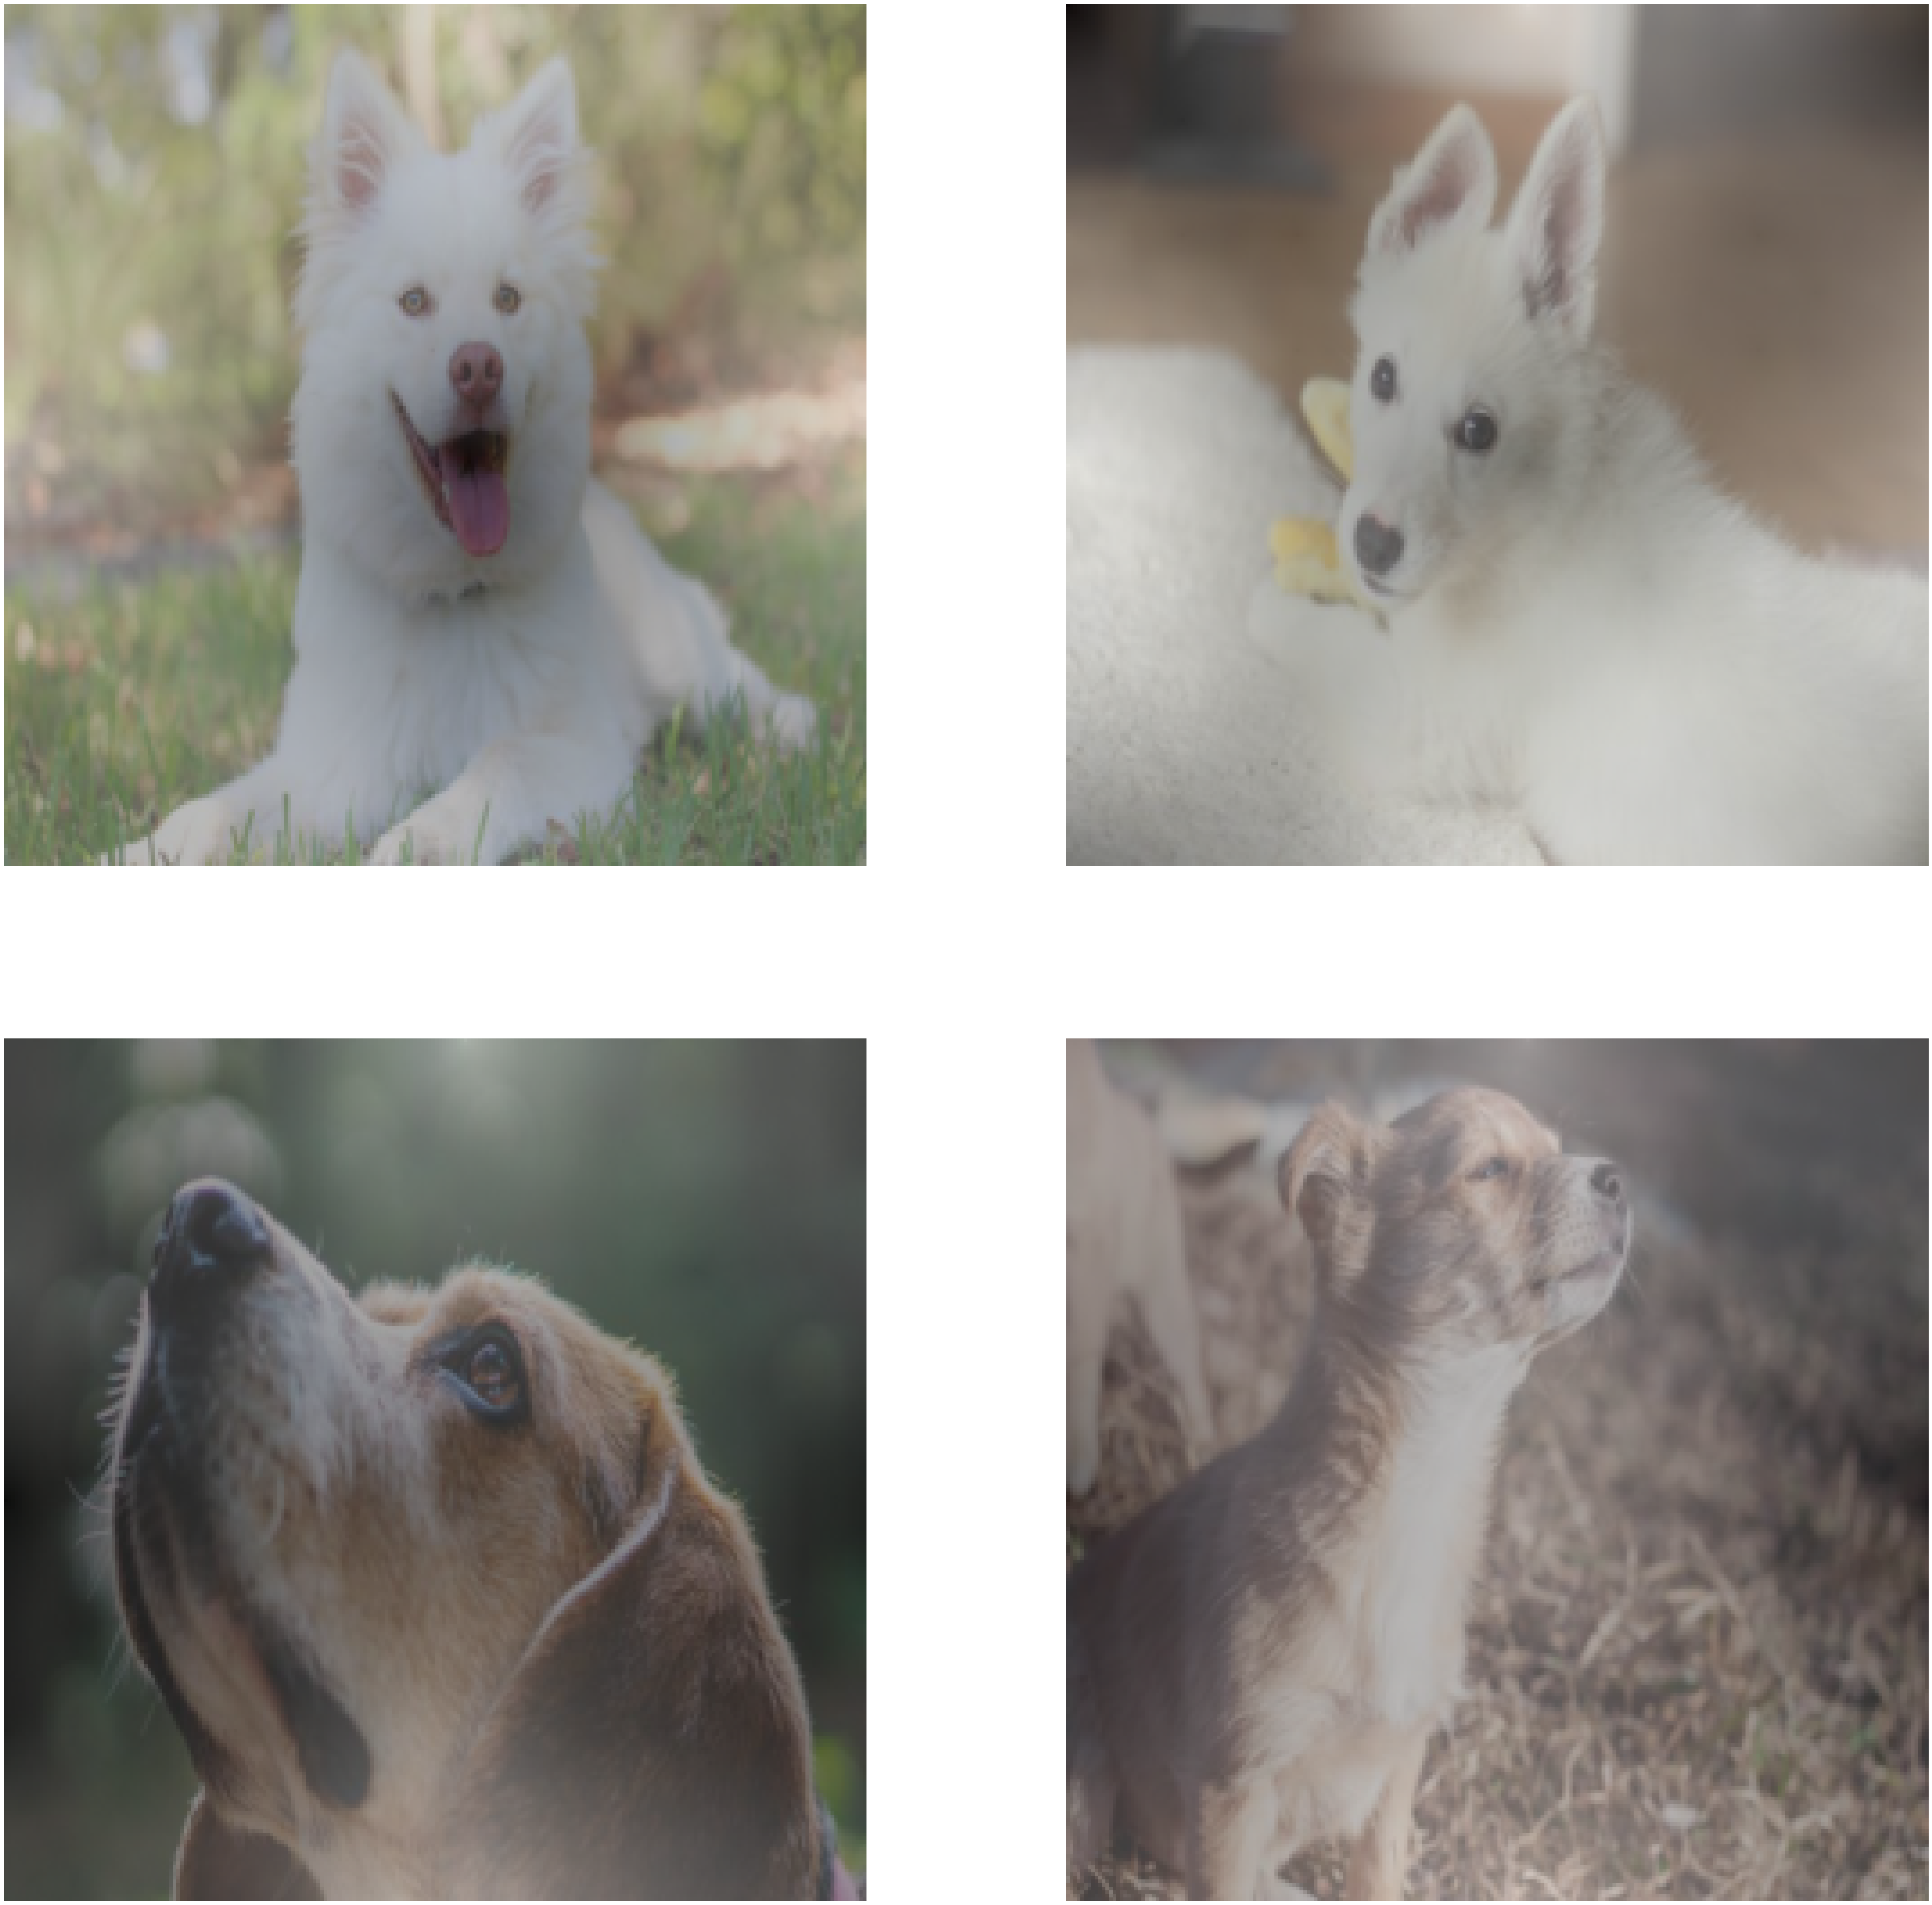

In [200]:
pipe_out = pipe.run()

out = np.uint8(pipe_out[0].as_cpu().as_array())
outRGB = np.copy(out)
for i in range(len(out)):
    outRGB[i] = cv2.cvtColor(out[i],cv2.COLOR_BGR2RGB)


img1 = outRGB[0]
img2 = outRGB[1]
img3 = outRGB[2]
img4 = outRGB[3]

show_images(outRGB)